## Strategy

The dataset consists of categorical and numeric attributes with binary label for each instance. Instead of using all attributes, relevant attributes are selected. Then, logistic regression and KNN algorithm are used for prediction. 

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

#### 1) Data preprocessing
To train the model, only relevant attributes are selected. To dismiss scale effects, the dataset is normalized by StandardScaler. 
Training dataset is divided into training and validation subsets. After tranining classification model, test the model on testing dataset. 

In [2]:
train = pd.read_csv('./train.csv', index_col=0)

numeric_cols = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE', 'QfE', 'QgE', 'QhE', 'QiE', 'QjE', 'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE',
                'QrE', 'QsE', 'QtE']

cate_cols = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA', 'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 'QpA', 'QqA',
             'QrA', 'QsA', 'QtA', 'education', 'engnat', 'familysize', 'hand', 'married', 'tp01', 'tp02', 'tp03',
            'tp04', 'tp05', 'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01', 'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 
            'wr_04', 'wr_05', 'wr_06', 'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13']

str_cols = ['age_group', 'gender', 'race', 'religion']

label = LabelEncoder()

for i in str_cols : 
    train[i] = label.fit_transform(train[i])
    
train[numeric_cols] = (train[numeric_cols] - train[numeric_cols].min()) / (train[numeric_cols].max() - train[numeric_cols].min())

In [3]:
from sklearn.model_selection import train_test_split
training, validation = train_test_split(train, test_size=0.3)

In [4]:
train.head(3)

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,0.000140,4.0,0.000241,5.0,0.001115,1.0,0.000643,2.0,0.000808,...,0,1,0,1,1,0,1,0,1,1
1,5.0,0.000258,5.0,0.000231,3.0,0.003858,5.0,0.001895,1.0,0.002237,...,1,1,0,1,1,0,1,0,1,1
2,4.0,0.000662,1.0,0.000261,1.0,0.001143,4.0,0.002156,5.0,0.000681,...,1,1,0,1,1,1,1,0,1,1


#### 2) KNN algorithm
Each instance checks labels from K nearest neighbors to determine its label. 

In [5]:
def distance(a, b):
    dist = np.sqrt(((a - b)**2).sum(axis=1))
    return dist

In [6]:
num = len(training)
val_num = len(validation)

dist_matrix = np.zeros(num*num).reshape(num, num)
val_dist_matrix = np.zeros(val_num*num).reshape(val_num, num)

In [7]:
arr_training = training.to_numpy()
arr_validation = validation.to_numpy()

for idx in range(val_num) : 
    val_dist_matrix[idx] = distance(arr_validation[idx], arr_training[:])

In [8]:
k_neighbors = [20, 30, 40, 50, 60, 70, 80, 90, 100]
hist_acc = [] 
for n_neighbors in k_neighbors : 
    val_pred = []
    
    for idx in range(val_num) :
        cols = np.argsort(val_dist_matrix[idx])[:n_neighbors]
        ix = Counter(training.iloc[cols].voted.values)
        ort = ix.most_common(1)[0][0]
        val_pred.append(ort)
    
    val_pred = np.array(val_pred)
    labels = validation.voted.to_numpy()
    acc = np.equal(val_pred, labels).sum() / val_num * 100
    hist_acc.append(acc)   

In [9]:
hist_acc

[72.34992679355783,
 73.01610541727672,
 73.45534407027819,
 73.14787701317717,
 73.30161054172767,
 73.73352855051245,
 73.5358711566618,
 73.49194729136164,
 73.46998535871157]

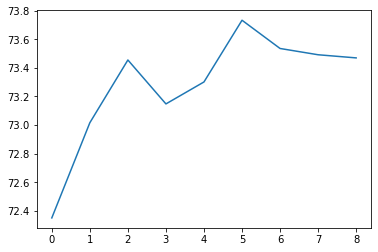

In [10]:
plt.plot(hist_acc)

#### 3) Test on testing dataset
According to above experiements, it seems that predicting the label from 2 neighbors looks promising. Therefore, each instance computes 2 nearest neighbors in training dataset to predict label for testing dataset. 

In [11]:
test = pd.read_csv('./test_x.csv', index_col=0)

label = LabelEncoder()

for i in str_cols : 
    test[i] = label.fit_transform(test[i])
    
test[numeric_cols] = (test[numeric_cols] - test[numeric_cols].min()) / (test[numeric_cols].max() - test[numeric_cols].min())

In [12]:
test_num = len(test)
test_dist_matrix = np.zeros(test_num*num).reshape(test_num, num)
arr_test = test.to_numpy()

In [13]:
test_pred = []
K = 70
for idx in range(test_num) : 
    test_dist_matrix[idx] = distance(arr_test[idx], arr_training[:,:-1])    
    cols = np.argsort(test_dist_matrix[idx])[:K]
    ix = Counter(training.iloc[cols].voted.values)
    ort = ix.most_common(1)[0][0]
    test_pred.append(ort)